## Autoencoder

Import Libraries

In [1]:
from keras.layers import Dense, Input 
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [2]:
np.random.seed(1337)

Load mnist data

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
image_size = x_train.shape[1]

In [7]:
x_train = np.reshape(x_train, [-1, image_size, image_size,1])
x_test  = np.reshape(x_test, [-1, image_size, image_size,1])
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255

## Adding noise

In [8]:
noise         = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise         = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy  = x_test + noise

Adding noise may exceed normalized pixel values because we used np.RANDOM.normal
Having normalized the values earlier, pixel values must not exceed 1.0 and must be greater than 0.0

In [9]:
x_train_noisy = np.clip(x_train_noisy, 0.,1.)
x_test_noisy  = np.clip(x_test_noisy, 0.,1.)

## Network Parameters

In [10]:
input_shape  = (image_size, image_size, 1)
batch_size   = 32
kernel_size  = 3
latent_dim   = 16
layer_filter = [32, 64]

## autoencoder Model using Functional API

ENCODER MODEL

In [15]:
inputs = Input(shape=input_shape, name='encoder_input')
x      = inputs

#Conv2D(32)-Conv2D(64)
for filters in layer_filter:
    x = Conv2D(filters     = filters,
               kernel_size = 3,
               strides     = 2,
               activation  = 'relu',
               padding     = 'same')(x)
    
shape = K.int_shape(x)

In [17]:
x      = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [18]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


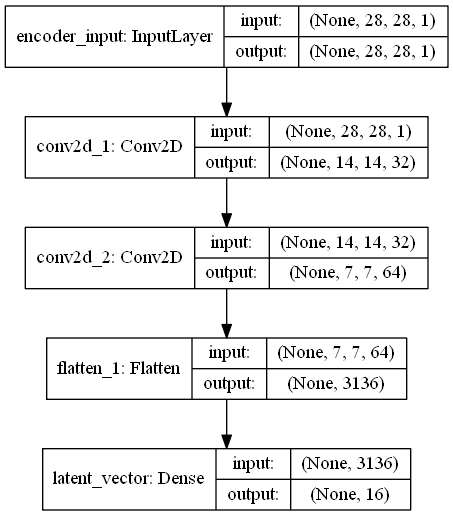

In [37]:
#import graphviz
#import pydot_ng as pydot
#from keras.utils import plot_model
#plot_model(encoder, to_file='encoder.png', show_shapes=True)

import keras 
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(encoder, to_file='encoder.png', show_shapes=True)

DECODER MODEL

In [27]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x             = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x             = Reshape((shape[1],shape[2],shape[3]))(x)

In [29]:
for filters in layer_filter[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [30]:
#reconstructing the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

In [31]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

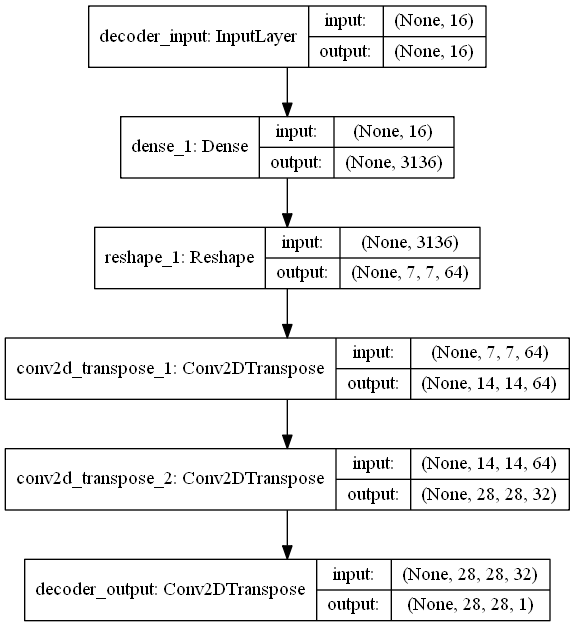

In [36]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

AUTOENCODER


Autoencoder = encoder + decoder

In [33]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


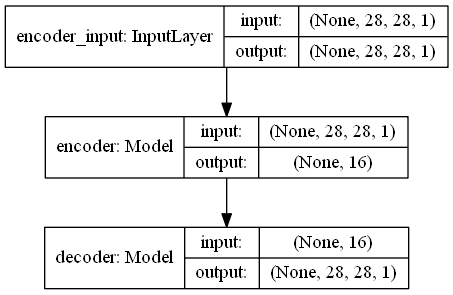

In [35]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [38]:
autoencoder.compile(loss='mse',optimizer='adam')

In [39]:
#training
autoencoder.fit(x_train_noisy,
                x_train,
               validation_data=(x_test_noisy,x_test),
               epochs=10,
               batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.0360 - val_loss: 0.0198
Epoch 2/10
60000/60000 [==============================] - 139s 2ms/step - loss: 0.0190 - val_loss: 0.0177
Epoch 3/10
60000/60000 [==============================] - 142s 2ms/step - loss: 0.0175 - val_loss: 0.0172
Epoch 4/10
60000/60000 [==============================] - 143s 2ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 5/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 6/10
60000/60000 [==============================] - 138s 2ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 7/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 8/10
60000/60000 [==============================] - 144s 2ms/step - loss: 0.0154 - val_loss: 0.0159
Epoch 9/10
60000/60000 [==============================] - 139s 2ms/step - loss: 0.0153 - val_loss: 0.0

## Prediction

In [40]:
x_decoded = autoencoder.predict(x_test_noisy)

In [47]:
rows, cols = 1, 3
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num],x_decoded[:num]])
imgs = imgs.reshape((rows*3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows*3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs*255).astype(np.uint8)

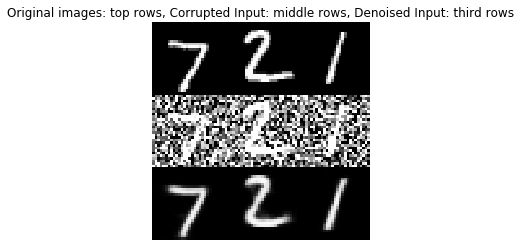

In [48]:
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input: third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupt.png')
plt.show()